In [3]:
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tqdm 
from collections import defaultdict

from itertools import combinations

In [3]:
df = pd.read_csv('outputs/analysis_lists/all_analysis_week_12.csv')
reg = pd.read_csv('feb16-mar15_data/beneficiary/ai_registration-20210216-20210315.csv', sep='\t')
call = pd.read_csv('feb16-mar15_data/call/older/call_data_week_1.csv', sep='\t')


In [4]:
complete_group = pd.read_csv('outputs/individual_clustering/weekly_kmeans_pilot_stats_40.csv')
all_user_ids = complete_group['user_id'].to_list()
rmab_group = pd.read_csv('outputs/pilot_outputs/rmab_pilot.csv')
round_robin_group = pd.read_csv('outputs/pilot_outputs/round_robin_pilot.csv')

rmab_user_ids = rmab_group['user_id'].to_list()
round_robin_user_ids = round_robin_group['user_id'].to_list()

In [5]:
interv_df = pd.DataFrame(columns=['user_id', 'intervene_week', 'intervene_date', 'exp_group'])
interv_calling_files = ['250_week1_290421', '400_week2_060521', '400_week3_120521', '400_week4_180521', '435_week5_240521', '600_week6_310521', '700_week7_070621', '1000_week8_140621', '1000_week9_210621', '1000_week10_280621', '1000_week11_050721']

from datetime import datetime
week_date_lookup = {f.split('_')[1]:datetime.strptime(f.split('_')[-1], '%d%m%y') for f in interv_calling_files}

for file in interv_calling_files:
    with open('outputs/pilot_generations/calling_list_{}.txt'.format(file), 'r') as fr:
        for line in fr:
            user_id = int(line.strip())
            interv_week = file.split('_')[1]
            exp_group = df[df['user_id']==user_id]['arm'].iloc[0]
            intervene_date = week_date_lookup[interv_week]
            interv_df = interv_df.append({'user_id': user_id, 'intervene_week': interv_week, 'intervene_date':intervene_date, 'exp_group': exp_group}, ignore_index=True)
interv_df = pd.merge(interv_df, reg[['user_id', 'registration_date']])  
interv_df = pd.merge(interv_df, df[['user_id', 'cluster']])
interv_df['registration_date'] = pd.to_datetime(interv_df['registration_date'])
interv_df['days_since_reg'] = (interv_df['intervene_date'] - interv_df['registration_date']).dt.days


In [32]:
interv_df[interv_df['intervene_week'].isin(['week1', 'week2', 'week3', 'week4', 'week5', 'week6', 'week7'])].groupby('exp_group')['user_id'].count()


exp_group
rmab           1610
round_robin    1575
Name: user_id, dtype: int64

In [33]:
600/3100

0.1935483870967742

In [6]:
calling_files = ['250_week1_290421', '400_week2_060521', '400_week3_120521', '400_week4_180521']

intervention_dict = {}
for file in calling_files:
    with open('outputs/pilot_generations/calling_list_{}.txt'.format(file), 'r') as fr:
        for line in fr:
            user_id = int(line.strip())
            if user_id not in intervention_dict:
                intervention_dict[user_id] = [file.split('_')[1]]
            else:
                intervention_dict[user_id].append(file.split('_')[1])

In [7]:
neha_list_weeks = ['week1', 'week2', 'week3', 'week4', 'week5', 'week6', 'week7']

opt_out_excel = pd.read_excel('neha_lists/optout_requests_week2.xlsx', header=None, engine='openpyxl')
opt_out_list_dict = dict(zip(neha_list_weeks, [set([]) for _ in neha_list_weeks]))
opt_out_list_dict['week2'] = set(opt_out_excel[0].to_list())

# opt_out_list = set([])
intervention_calling_status = []
intervention_calling_status_list = []

for idx, neha_list_week in enumerate(neha_list_weeks):
    df_excel = pd.read_excel('neha_lists/neha_calling_status_{}.xlsx'.format(neha_list_week), engine='openpyxl')
    intervention_calling_status.append(df_excel)
    intervention_calling_status_list.append(intervention_calling_status[-1]['UserID'].to_list())
    print(idx)
    if idx > 1:
        curr_user_list = df_excel['UserID'].to_list()
        for user in curr_user_list:
            row_excel = df_excel[df_excel['UserID'] == user]
            try:
                opt_out = row_excel['Opt Out'].item()
            except:
                print(user)
                continue
            if idx <= 3:
                if type(opt_out) == type('str') and len(opt_out.strip()) > 0:
                    opt_out_list_dict[neha_list_week].add(user)
            else:
                if type(opt_out) == type('str') and opt_out.strip().lower() == 'yes':
                    opt_out_list_dict[neha_list_week].add(user)

0
1
2
3
4
5
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
6


In [8]:
skip_categories = ['disconnected', 'out of coverage', 'ringing', 'switched off', 'network busy' , 'successful call']

rmab_filtered_ids = []
dropped_dict = dict(zip(neha_list_weeks, [[] for _ in neha_list_weeks]))

for idx, neha_list_week in enumerate(neha_list_weeks):
    for user_id in list(rmab_user_ids):
        if user_id in intervention_dict and len(intervention_dict[user_id]) >= 3: 
            # if a user has been called 3 times or more: DONT INCLUDE
            print('called 3 or more times already')
            dropped_dict[neha_list_week].append(user_id)
            continue
        if user_id not in opt_out_list_dict[neha_list_week]:
            ## if user in Opt out list: DONT INCLUDE
            flag = True
            for i in range(len(intervention_calling_status_list)):
                if user_id in intervention_calling_status_list[i]: # If we have status of that user ID
                    int_call_status = intervention_calling_status[i][intervention_calling_status[i]['UserID'] == user_id]['Call Outcome'].item()
                    if type(int_call_status) == type('str') and int_call_status.lower() not in skip_categories:
                        # If call status is other than skip cats: DONT INCLUDE
                        flag = False
                        dropped_dict[neha_list_week].append(user_id)
                        print(int_call_status)
            if flag:
                rmab_filtered_ids.append(user_id)
        else:
            dropped_dict[neha_list_week].append(user_id)
            print('In opt out list')

called 3 or more times already
Number not in service
Number not in service
Not an eligible subscriber
Ineligible beneficiary
Ineligible beneficiary
called 3 or more times already
Number not in service
Number not in service
Invalid Number
Invalid Number
Wrong Number
Wrong number
Wrong Number
Wrong number
called 3 or more times already
called 3 or more times already
called 3 or more times already
Invalid Number
Invalid Number
Number not in service
Number not in service
Invalid Number
Invalid Number
Not an eligible subscriber
Ineligible beneficiary
called 3 or more times already
Not an eligible subscriber
Ineligible beneficiary
called 3 or more times already
called 3 or more times already
Incoming Stopped
Incoming Stopped
Not an eligible subscriber
Ineligible beneficiary
called 3 or more times already
Not an eligible subscriber
Ineligible beneficiary
called 3 or more times already
Invalid Number
Invalid Number
Invalid Number
Invalid Number
called 3 or more times already
called 3 or more t

Ineligible beneficiary
Invalid Number
In opt out list
In opt out list
Ineligible beneficiary
Ineligible beneficiary
Wrong Number
Incoming Stopped
Ineligible beneficiary
Ineligible beneficiary
Incoming Stopped
Wrong Number
Incoming Stopped
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Wrong Number
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Incoming Stopped
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Incoming Stopped
Ineligible beneficiary
Ineligible beneficiary
In opt out list
Invalid Number
Ineligible beneficiary
Wrong Number
Wrong Number
Ineligible beneficiary
Incoming Stopped
Number not in service
Ineligible beneficiary
Incoming Stopped
Incoming Stopped
Wrong Number
Incoming Stopped
Wrong Number
Incoming Stopped
Temporarily suspended
Number not in servi

Wrong person
Wrong person
Incoming Stopped
Invalid Number
Number not in service
Invalid Number
Invalid Number
Number not in service
Wrong Person
Incoming Stopped
Wrong Number
Incoming Stopped
Incoming Stopped
Wrong Number
फोन नंबर गलत है
Incoming Stopped
Wrong Person
Wrong Person
Incoming Stopped
Refuse to Respond
In opt out list
Ineligible beneficiary
Incoming Stopped
Wrong Number
Number not in service
Number not in service
In opt out list
Wrong number
Incoming Stopped
Ineligible beneficiary
Incoming Stopped
Incoming Stopped
Incoming Stopped
Wrong person
Incoming Stopped
Wrong person
Wrong number
Wrong Number
Wrong person
Incoming Stopped
Incoming Stopped
Wrong number
Ineligible beneficiary
Incoming Stopped
Ineligible beneficiary
Ineligible beneficiary
Wrong Number
Number not in service
In opt out list
Ineligible beneficiary
Ineligible beneficiary
Incoming Stopped
Wrong Number
Incoming Stopped
Ineligible beneficiary
Incoming Stopped
Ineligible beneficiary
Incoming Stopped
Ineligible b

Number temporarily suspended
Incoming Stopped
Incoming stopped
Not an eligible subscriber
Ineligible beneficiary
Number temporarily suspended
Number temporarily suspended
Incoming Stopped
Incoming stopped
Invalid Number
Wrong Number
Incoming Stopped
Incoming Stopped
Number not in service
Number not in service
Number not in service
Number not in service
Incoming Stopped
Incoming Stopped
Incoming Stopped
Incoming Stopped
Incoming Stopped
Not an eligible subscriber
Ineligible beneficiary
Invalid Number
Incoming Stopped
Incoming Stopped
Number temporarily suspended
Number temporarily suspended
Number not in service
Incoming Stopped
Wrong number
Number not in service
Invalid Number
Incoming Stopped
Ineligible beneficiary
Incoming Stopped
Invalid Number
Number not in service
Ineligible beneficiary
Incoming Stopped
Ineligible beneficiary
Incoming Stopped
Number not in service
Invalid Number
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Incoming Stopped
Ineligible benefi

Ineligible beneficiary
Incoming Stopped
Ineligible beneficiary
Ineligible beneficiary
Ineligible beneficiary
Invalid Number
Invalid Number
Incoming Stopped
Ineligible beneficiary
Ineligible beneficiary
Invalid Number
Wrong Number
Invalid Number
Incoming Stopped
Number not in service
Wrong Number
Ineligible beneficiary
Incoming Stopped
Incoming Stopped
Invalid Number
Nu
Incoming Stopped
Wrong Number
Wrong number
Incoming Stopped
Ineligible beneficiary
Ineligible beneficiary
Invalid Number
Invalid Number
Invalid Number
Incoming Stopped
Incoming Stopped
Incoming Stopped
Invalid Number
In opt out list
Ineligible beneficiary
Ineligible beneficiary
Wrong Number
Incoming Stopped
Busy
Wrong number
In opt out list
Incoming Stopped
Number not in service
In opt out list
Incoming Stopped
Wrong number
Incoming Stopped
In opt out list
Incoming Stopped
Wrong number
Wrong person
In opt out list
Wrong person
In opt out list
In opt out list
Temporarily suspended
Temporarily suspended
Incoming Stopped
In

Incoming Stopped
In opt out list
Incoming Stopped
Incoming Stopped
Invalid Number
Incoming Stopped
Busy
Wrong number
Incoming Stopped
Incoming Stopped
In opt out list
Wrong person
In opt out list
In opt out list
Incoming Stopped
Wrong person
Invalid Number
In opt out list
Incoming Stopped
Incoming Stopped
Invalid Number
In opt out list
In opt out list
Wrong person
Wrong person
In opt out list
In opt out list
Wrong person
Incoming Stopped
In opt out list
Invalid Number
Invalid Number
Wrong Number
Incoming Stopped
Incoming Stopped
Incoming Stopped
Incoming Stopped
Wrong Number
Number not in service
Wrong Number
Wrong Number
Number not in service
Incoming Stopped
Invalid Number
Incoming Stopped
Number not in service
Incoming Stopped
Number not in service
Invalid Number
Wrong Number
Wrong Person
Incoming Stopped
Number temporarily suspended
Wrong Person
Incoming Stopped
Incoming Stopped
Wrong Person
Number not in service
Incoming Stopped
Number temporarily suspended
Number not in service
W

In [9]:
[len(set(dropped_dict[i])) for i in dropped_dict]
# dropped_dict

[342, 381, 353, 363, 362, 386, 387]

In [10]:
[len(set(dropped_dict[i])) for i in dropped_dict]


[342, 381, 353, 363, 362, 386, 387]

In [11]:
dropped_dict.keys()

dict_keys(['week1', 'week2', 'week3', 'week4', 'week5', 'week6', 'week7'])

In [12]:
all_dropped = {}
for i in range(len(dropped_dict)):
    all_dropped[f'week{i+1}'] = set(dropped_dict[f'week{i+1}'])
    if i>0:
        all_dropped[f'week{i+1}'] = all_dropped[f'week{i+1}'].union(all_dropped[f'week{i}'])
for i in range(8, 12):
    all_dropped[f'week{i}'] = all_dropped['week7']

In [13]:
[(len(all_dropped[i]), i) for i in all_dropped]

[(342, 'week1'),
 (381, 'week2'),
 (392, 'week3'),
 (413, 'week4'),
 (433, 'week5'),
 (477, 'week6'),
 (522, 'week7'),
 (522, 'week8'),
 (522, 'week9'),
 (522, 'week10'),
 (522, 'week11')]

In [14]:
[(len(all_dropped[i]), i) for i in all_dropped]

[(342, 'week1'),
 (381, 'week2'),
 (392, 'week3'),
 (413, 'week4'),
 (433, 'week5'),
 (477, 'week6'),
 (522, 'week7'),
 (522, 'week8'),
 (522, 'week9'),
 (522, 'week10'),
 (522, 'week11')]

In [15]:
bad_users = state_jumps_df[state_jumps_df[[f'is_intervened_week{i}' for i in range(1,5)]].sum(axis=1)>1]['user_id'].values


NameError: name 'state_jumps_df' is not defined

In [ ]:
df[df.user_id.isin(all_dropped['week3'])]['arm'].value_counts()

In [ ]:
# with open('drop_list.pickle', 'wb') as handle:
#     pickle.dump(all_dropped, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('filename.pickle', 'rb') as handle:
#     b = pickle.load(handle)

In [ ]:
df

# Load transition prob and starting states


In [4]:
with open('policy_dump.pkl', 'rb') as fr:
  pilot_user_ids, pilot_static_features, cls, cluster_transition_probabilities, m_values, q_values = pickle.load(fr)
fr.close()

/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/vermashresth/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [18]:
analysis_df = pd.read_csv('outputs/state-cluster-whittle-E_C.csv')

In [19]:
state_jumps_df = pd.merge(interv_df[['user_id', 'exp_group', 'intervene_week']], analysis_df[['user_id']+[g for g in analysis_df.columns if g.endswith('state')]])

state_jumps_df['value'] = 1
pivoted_df = state_jumps_df.pivot(index='user_id', columns='intervene_week', values='value').fillna(0)
pivoted_df.columns = [f'is_intervened_{i}' for i in pivoted_df.columns]
state_jumps_df = pd.merge(state_jumps_df, pivoted_df.reset_index())
state_jumps_df = state_jumps_df.drop(columns=['intervene_week', 'value']).drop_duplicates()
state_jumps_df

,user_id,exp_group,week0_state,week1_state,week2_state,week3_state,week4_state,week5_state,week6_state,week7_state,...,is_intervened_week10,is_intervened_week11,is_intervened_week2,is_intervened_week3,is_intervened_week4,is_intervened_week5,is_intervened_week6,is_intervened_week7,is_intervened_week8,is_intervened_week9
0,2393699,rmab,7,1,1,1,7,7,7,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2387277,round_robin,7,1,0,0,6,6,6,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2401025,rmab,7,1,1,1,1,1,1,7,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,2398556,rmab,7,1,1,1,7,7,7,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2388715,round_robin,7,1,1,1,7,7,7,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7180,2395228,round_robin,7,7,7,7,7,7,7,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7181,2395195,round_robin,6,7,7,7,6,7,7,7,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7182,2392191,round_robin,7,7,7,7,6,7,7,6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7183,2394510,round_robin,6,6,6,6,6,6,6,6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
state_jumps_df[['week0_state_comb', 'week6_state_comb', 'week7_state_comb']] = (state_jumps_df[['week0_state', 'week6_state', 'week7_state']]%2).astype(int)

print(state_jumps_df[(state_jumps_df['is_intervened_week1']==1) & 
                     (state_jumps_df['exp_group']=='rmab') & 
                     (state_jumps_df['week0_state_comb']==1)].groupby(['week0_state_comb', 'week7_state_comb'])['user_id'].count()/125)
print(state_jumps_df[(state_jumps_df['is_intervened_week1']==1) & 
                     (state_jumps_df['exp_group']=='round_robin')& 
                     (state_jumps_df['week0_state_comb']==1)].groupby(['week0_state_comb', 'week7_state_comb'])['user_id'].count()/80)



week0_state_comb  week7_state_comb
1                 0                   0.312
                  1                   0.688
Name: user_id, dtype: float64
week0_state_comb  week7_state_comb
1                 0                   0.1375
                  1                   0.8625
Name: user_id, dtype: float64


In [21]:
print(state_jumps_df[(state_jumps_df['is_intervened_week1']==1) & 
                     (state_jumps_df['exp_group']=='rmab')].groupby(['week0_state_comb'])['user_id'].count()/125)
print(state_jumps_df[(state_jumps_df['is_intervened_week1']==1) & 
                     (state_jumps_df['exp_group']=='round_robin')].groupby(['week0_state_comb'])['user_id'].count()/125)



week0_state_comb
1    1.0
Name: user_id, dtype: float64
week0_state_comb
0    0.36
1    0.64
Name: user_id, dtype: float64


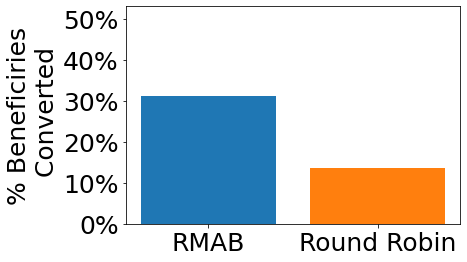

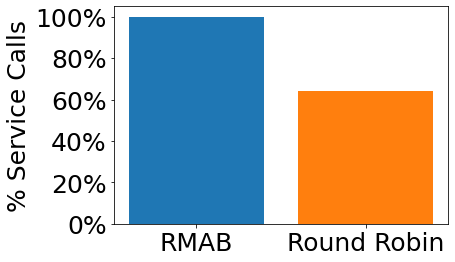

In [29]:
fig=plt.figure(figsize=(6,4))
# plt.subplot(1,2,1)
plt.bar([0], [31.2])
plt.bar([1], [13.7])
plt.xticks([0,1], ['RMAB', 'Round Robin'], fontsize=25)
plt.yticks(range(0, 60, 10), [str(i)+'%' for i in range(0,60,10)], fontsize=25)
plt.margins(y=0.7)
plt.ylabel('% Beneficiries\n Converted', fontsize=25)
# plt.title('Non-Engaging to Engaging Conversion Rate', fontsize=11)


fig=plt.figure(figsize=(6,4))
# plt.subplot(1,2,2)
plt.bar([0], [100])
plt.bar([1], [64])
plt.xticks([0,1], ['RMAB', 'Round Robin'], fontsize=25)
plt.yticks(range(0, 110, 20), [str(i)+'%' for i in range(0,110,20)], fontsize=25)
plt.ylabel('% Service Calls', fontsize=25)
# plt.title('Percentage Intervention Resources Spent on Non-Enagaging Beneficiaries', fontsize=9)


plt.show()

In [77]:
# state_jumps_df[[col for col in state_jumps_df.columns if col.endswith('state')]] = (state_jumps_df[[col for col in state_jumps_df.columns if col.endswith('state')]] % 2).astype(int).replace({0:'E', 1:'NE'})
for week in range(1, 6):
    sub = state_jumps_df[state_jumps_df[f'is_intervened_week{week}']==1]
    print(sub.groupby(['exp_group', f'week{week-1}_state'])['user_id'].count()/len(sub)*200)

exp_group    week0_state
rmab         NE             100.0
round_robin  E               36.0
             NE              64.0
Name: user_id, dtype: float64
exp_group    week1_state
rmab         E              50.0
             NE             50.0
round_robin  E              42.0
             NE             58.0
Name: user_id, dtype: float64
exp_group    week2_state
rmab         E              33.5
             NE             66.5
round_robin  E              41.0
             NE             59.0
Name: user_id, dtype: float64
exp_group    week3_state
rmab         E              64.5
             NE             35.5
round_robin  E              45.0
             NE             55.0
Name: user_id, dtype: float64
exp_group    week4_state
rmab         E              98.390805
             NE              9.655172
round_robin  E              42.758621
             NE             49.195402
Name: user_id, dtype: float64


In [ ]:
E - E - 32
E-NE - 13
NE-E - 17
NE-NE - 63


NE-E - 29.6
NE-NE - 70.4


In [52]:
week 5 state
eng - 35
ne - 90

week4 state
e - 37
ne - 88



SyntaxError: invalid syntax (<ipython-input-52-38e4d4864fc8>, line 1)

In [53]:
88/125

0.704

In [47]:
analysis_df

,Unnamed: 0,user_id,cluster,arm,registration_date,intervention_week,week1_whittle,after_intervention_E/C,week0_E/C,week0_state,...,week8_whittle,week9_E/C,week9_state,week9_whittle,week10_E/C,week10_state,week10_whittle,week11_E/C,week11_state,week11_whittle
0,0,2394384,29,rmab,1144.0,week1,0.000000,20/20,0/2,7,...,-0.387939,2/2,6,-0.387939,2/2,6,-0.387939,2/2,6,-0.387939
1,1,2388891,29,control,1134.0,NaN,0.865692,0/0,0/0,7,...,0.865692,1/2,6,-0.387939,0/0,7,0.865692,0/0,7,0.865692
2,2,2404208,29,round_robin,1158.0,NaN,-0.387939,0/0,0/0,7,...,-0.387939,0/0,7,0.865692,0/0,7,0.865692,0/0,7,0.865692
3,3,2388931,29,rmab,1144.0,week1,0.000000,14/20,0/2,7,...,-0.387939,2/2,6,-0.387939,2/2,6,-0.387939,2/2,6,-0.387939
4,4,2392202,29,rmab,1137.0,week1,0.000000,0/0,0/0,7,...,0.865692,0/0,7,0.865692,0/0,7,0.865692,0/0,7,0.865692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22998,22998,2400463,34,control,1157.0,NaN,-0.882812,0/0,0/0,7,...,-0.882812,0/0,7,-0.882812,0/0,7,-0.882812,0/0,7,-0.882812
22999,22999,2398012,34,rmab,1155.0,NaN,-0.882812,0/0,0/1,7,...,-0.882812,0/0,7,-0.882812,0/0,7,-0.882812,0/1,7,-0.882812
23000,23000,2397484,34,control,1142.0,NaN,-0.882812,0/0,0/0,7,...,-0.882812,0/0,7,-0.882812,0/2,7,-0.882812,0/0,7,-0.882812
23001,23001,2397539,34,rmab,1151.0,NaN,-0.882812,0/0,0/1,7,...,-0.882812,0/2,7,-0.882812,0/0,7,-0.882812,1/1,6,0.145004


In [233]:
for i in range(7):
    print(f'-------Women intervened on in week {i+1}-------')
    print()
    filter_df = state_jumps_df[(state_jumps_df[f'is_intervened_week{i+1}']==1) &
                        (state_jumps_df['exp_group']=='rmab')]
    print('Total women intervened: ', len(filter_df))
    filter_df = filter_df[~(filter_df['user_id'].isin(bad_users))]
    print('Total women intervened after removing bad interventions: ', len(filter_df) )
    print(f'State Distribution of these Women in Week {i} ')
    print(filter_df[f'week{i}_state'].value_counts()/len(filter_df)*100)
    print()
#     if i==0:
#         print(f'women for week {i+1+1+4}')
#         print('Women who have dropped out by now: ')
#         print(filter_df[filter_df['user_id'].isin(list(all_dropped[f'week{i+1+4}']))].shape[0])
#         filter_df = filter_df[~filter_df['user_id'].isin(list(all_dropped[f'week{i+1+4}']))]
#         print('Intervention matrix for remaining women' )
#         display(filter_df.groupby([f'week{i+1+4}_state', f'is_intervened_week{i+1+1+4}'])['user_id'].count()/len(filter_df)*100)
#         print('E/NE: ', filter_df.groupby([f'week{i+1+4}_state'])['user_id'].count()/len(filter_df)*100)

#     else:
    print(f'women for week {i+1+4}')
    print('Women who have dropped out by now: ')
    print(filter_df[filter_df['user_id'].isin(list(all_dropped[f'week{i+4}']))].shape[0])
    filter_df = filter_df[~filter_df['user_id'].isin(list(all_dropped[f'week{i+4}']))]
    print('Intervention matrix for remaining women' )
    display(filter_df.groupby([f'week{i+4}_state', f'is_intervened_week{i+1+4}'])['user_id'].count()/len(filter_df)*100)
    print('E/NE ', filter_df.groupby([f'week{i+4}_state'])['user_id'].count()/len(filter_df)*100)
    print()
    print()
    

-------Women intervened on in week 1-------

Total women intervened:  125
Total women intervened after removing bad interventions:  96
State Distribution of these Women in Week 0 
7    100.0
Name: week0_state, dtype: float64

women for week 5
Women who have dropped out by now: 
34
Intervention matrix for remaining women


week4_state  is_intervened_week5
6            0.0                    50.0
7            0.0                    50.0
Name: user_id, dtype: float64

E/NE  week4_state
6    50.0
7    50.0
Name: user_id, dtype: float64


-------Women intervened on in week 2-------

Total women intervened:  200
Total women intervened after removing bad interventions:  176
State Distribution of these Women in Week 1 
6    53.409091
7    46.590909
Name: week1_state, dtype: float64

women for week 6
Women who have dropped out by now: 
33
Intervention matrix for remaining women


week5_state  is_intervened_week6
6            0.0                    15.384615
             1.0                    48.251748
7            0.0                    11.188811
             1.0                    25.174825
Name: user_id, dtype: float64

E/NE  week5_state
6    63.636364
7    36.363636
Name: user_id, dtype: float64


-------Women intervened on in week 3-------

Total women intervened:  200
Total women intervened after removing bad interventions:  175
State Distribution of these Women in Week 2 
7    61.714286
6    38.285714
Name: week2_state, dtype: float64

women for week 7
Women who have dropped out by now: 
50
Intervention matrix for remaining women


week6_state  is_intervened_week7
6            0.0                    19.2
             1.0                    36.8
7            0.0                    11.2
             1.0                    32.8
Name: user_id, dtype: float64

E/NE  week6_state
6    56.0
7    44.0
Name: user_id, dtype: float64


-------Women intervened on in week 4-------

Total women intervened:  200
Total women intervened after removing bad interventions:  153
State Distribution of these Women in Week 3 
6    80.392157
7    19.607843
Name: week3_state, dtype: float64

women for week 8
Women who have dropped out by now: 
23
Intervention matrix for remaining women


week7_state  is_intervened_week8
6            0.0                    10.000000
             1.0                    63.076923
7            0.0                    20.000000
             1.0                     6.923077
Name: user_id, dtype: float64

E/NE  week7_state
6    73.076923
7    26.923077
Name: user_id, dtype: float64


-------Women intervened on in week 5-------

Total women intervened:  235
Total women intervened after removing bad interventions:  235
State Distribution of these Women in Week 4 
6    91.06383
7     8.93617
Name: week4_state, dtype: float64

women for week 9
Women who have dropped out by now: 
17
Intervention matrix for remaining women


week8_state  is_intervened_week9
6            0.0                     6.880734
             1.0                    71.559633
7            0.0                    20.183486
             1.0                     1.376147
Name: user_id, dtype: float64

E/NE  week8_state
6    78.440367
7    21.559633
Name: user_id, dtype: float64


-------Women intervened on in week 6-------

Total women intervened:  300
Total women intervened after removing bad interventions:  300
State Distribution of these Women in Week 5 
6    55.333333
7    44.666667
Name: week5_state, dtype: float64

women for week 10
Women who have dropped out by now: 
42
Intervention matrix for remaining women


week9_state  is_intervened_week10
6            0.0                     10.077519
             1.0                     48.062016
7            0.0                     11.240310
             1.0                     30.620155
Name: user_id, dtype: float64

E/NE  week9_state
6    58.139535
7    41.860465
Name: user_id, dtype: float64


-------Women intervened on in week 7-------

Total women intervened:  350
Total women intervened after removing bad interventions:  349
State Distribution of these Women in Week 6 
6    73.352436
7    26.647564
Name: week6_state, dtype: float64

women for week 11
Women who have dropped out by now: 
40
Intervention matrix for remaining women


week10_state  is_intervened_week11
6             0.0                      4.854369
              1.0                     57.605178
7             0.0                     18.446602
              1.0                     19.093851
Name: user_id, dtype: float64

E/NE  week10_state
6    62.459547
7    37.540453
Name: user_id, dtype: float64




In [53]:
i = 0
master_df = pd.merge(state_jumps_df, analysis_df[['user_id', 'cluster']])[['user_id', 'exp_group', 'week0_state', 'week4_state', 'is_intervened_week1', 'is_intervened_week5', 'cluster']]
master_df = master_df[master_df['exp_group']=='rmab']
master_df['week0_mval'] = master_df.apply(lambda x: m_values[x['cluster'], x['week0_state']], axis=1)
master_df['week4_mval'] = master_df.apply(lambda x: m_values[x['cluster'], x['week4_state']], axis=1)

filter_df = master_df[(master_df[f'is_intervened_week{i+1}']==1) &
                        (master_df['exp_group']=='rmab')]
filter_df ## users who were intervened in week 1 - their week 0, 4 states, clusters and week 5 intervention status 


,user_id,exp_group,week0_state,week4_state,is_intervened_week1,is_intervened_week5,cluster,week0_mval,week4_mval
0,2393699,rmab,7,7,1.0,0.0,1,0.836349,0.836349
2,2401025,rmab,7,1,1.0,0.0,1,0.836349,0.000000
3,2398556,rmab,7,7,1.0,0.0,29,0.865692,0.865692
5,2399352,rmab,7,7,1.0,0.0,29,0.865692,0.865692
9,2398340,rmab,7,6,1.0,0.0,1,0.836349,-0.467957
...,...,...,...,...,...,...,...,...,...
239,2387495,rmab,7,1,1.0,0.0,36,0.828232,0.000000
240,2405414,rmab,7,7,1.0,0.0,37,0.824566,0.824566
241,2399851,rmab,7,7,1.0,0.0,29,0.865692,0.865692
246,2396869,rmab,7,7,1.0,0.0,29,0.865692,0.865692


In [54]:
filter_df.groupby(['week0_state', 'cluster'])['user_id'].count()

week0_state  cluster
7            1          49
             29         58
             36         13
             37          5
Name: user_id, dtype: int64

In [55]:
out = master_df.groupby(['week0_state', 'cluster']).agg({'user_id':'count', 'week0_mval': 'max', 'is_intervened_week1': 'mean'})
out.sort_values('week0_mval')

user_id  week0_mval  is_intervened_week1
week0_state cluster                                          
7           15             2   -0.587753             0.000000
6           12            16   -0.545204             0.000000
            1             50   -0.467957             0.000000
            29            23   -0.387939             0.000000
7           32            16   -0.350891             0.000000
6           37            23   -0.212509             0.000000
            33            38   -0.075363             0.000000
7           3            112   -0.074402             0.000000
            27            52   -0.040573             0.000000
6           21            43   -0.030930             0.000000
            13             2   -0.023361             0.000000
7           0             65   -0.013618             0.000000
            26             1   -0.012283             0.000000
            35           386   -0.003605             0.000000
6           36             3    0.120392             0.000000
7           28             1    0.124466             0.000000
            24            19    0.252083             0.000000
            13             9    0.380714             0.000000
6           35           795    0.394157             0.000000
            15             9    0.412399             0.000000
7           21            51    0.452606             0.000000
6           3            188    0.465172             0.000000
            24            28    0.465698             0.000000
            32            29    0.587952             0.000000
            0            137    0.590164             0.000000
7           33            90    0.607773             0.000000
            12            29    0.620995             0.000000
6           27            87    0.630928             0.000000
7           37            42    0.824566             0.119048
            36            13    0.828232             1.000000
            1             49    0.836349             1.000000
            29            58    0.865692             1.000000

In [56]:
filter_df.groupby(['week4_state', 'cluster'])['user_id'].count()

week4_state  cluster
0            29          3
1            1          11
             29         11
             36          3
             37          1
6            1          15
             29         11
             36          6
             37          2
7            1          23
             29         33
             36          4
             37          2
Name: user_id, dtype: int64

In [57]:
out = master_df.groupby(['week4_state', 'cluster']).agg({'user_id':'count', 'week4_mval': 'max'}).reset_index()
out.sort_values('week4_mval', ascending=False)

,week4_state,cluster,user_id,week4_mval
45,7,29,36,0.865692
37,7,1,30,0.836349
49,7,36,5,0.828232
50,7,37,2,0.824566
29,6,27,4,0.630928
39,7,12,1,0.620995
47,7,33,9,0.607773
21,6,0,15,0.590164
31,6,32,10,0.587952
28,6,24,29,0.465698


In [58]:
#Women who were intervened in week 1 cluster 29 - NE
filter_df[filter_df['cluster']==29]

,user_id,exp_group,week0_state,week4_state,is_intervened_week1,is_intervened_week5,cluster,week0_mval,week4_mval
3,2398556,rmab,7,7,1.0,0.0,29,0.865692,0.865692
5,2399352,rmab,7,7,1.0,0.0,29,0.865692,0.865692
11,2393884,rmab,7,1,1.0,0.0,29,0.865692,0.000000
12,2390925,rmab,7,7,1.0,0.0,29,0.865692,0.865692
25,2393621,rmab,7,7,1.0,0.0,29,0.865692,0.865692
26,2393680,rmab,7,1,1.0,0.0,29,0.865692,0.000000
30,2399732,rmab,7,7,1.0,0.0,29,0.865692,0.865692
33,2399409,rmab,7,1,1.0,0.0,29,0.865692,0.000000
35,2396177,rmab,7,7,1.0,0.0,29,0.865692,0.865692
37,2386375,rmab,7,6,1.0,0.0,29,0.865692,-0.387939


In [59]:
master_df[(master_df['is_intervened_week5']==1) & (master_df['cluster']==29)]

,user_id,exp_group,week0_state,week4_state,is_intervened_week1,is_intervened_week5,cluster,week0_mval,week4_mval
1523,2392101,rmab,6,7,0.0,1.0,29,-0.387939,0.865692
1676,2388566,rmab,6,7,0.0,1.0,29,-0.387939,0.865692
1739,2408361,rmab,6,7,0.0,1.0,29,-0.387939,0.865692


In [61]:
master_df[master_df['is_intervened_week5']==1].sort_values('week4_mval')

,user_id,exp_group,week0_state,week4_state,is_intervened_week1,is_intervened_week5,cluster,week0_mval,week4_mval
1343,2396253,rmab,6,6,0.0,1.0,3,0.465172,0.465172
1588,2397137,rmab,6,6,0.0,1.0,3,0.465172,0.465172
1592,2406593,rmab,6,6,0.0,1.0,3,0.465172,0.465172
1606,2393211,rmab,7,6,0.0,1.0,3,-0.074402,0.465172
1609,2398520,rmab,6,6,0.0,1.0,3,0.465172,0.465172
...,...,...,...,...,...,...,...,...,...
1726,2404593,rmab,6,7,0.0,1.0,1,-0.467957,0.836349
1744,2388754,rmab,6,7,0.0,1.0,1,-0.467957,0.836349
1523,2392101,rmab,6,7,0.0,1.0,29,-0.387939,0.865692
1676,2388566,rmab,6,7,0.0,1.0,29,-0.387939,0.865692


In [96]:
master_df.shape


(2466, 9)

In [113]:
print('ppl intervened in week 1')
display(filter_df['cluster'].value_counts())
# print('\n ppl dropped by week 4')
# filter_df[(filter_df.user_id.isin(dropped_ppl)) & filter_df['week4_state'].isin([7,1])]['cluster'].value_counts(),
print('NE ppl in week 4 (who were intervened in week 1) which were not dropped by now')
display(master_df[(master_df.user_id.isin(filter_df.user_id.values)) &
                   ~(master_df['user_id'].isin(dropped_ppl)) &
                 (master_df['week4_state'].isin([7, 1, 0]))])

ppl intervened in week 1


29    58
1     49
36    13
37     5
Name: cluster, dtype: int64

NE ppl in week 4 (who were intervened in week 1) which were not dropped by now


,user_id,exp_group,week0_state,week4_state,is_intervened_week1,is_intervened_week5,cluster,week0_mval,week4_mval
11,2393884,rmab,7,1,1.0,0.0,29,0.865692,0.000000
12,2390925,rmab,7,7,1.0,0.0,29,0.865692,0.865692
30,2399732,rmab,7,7,1.0,0.0,29,0.865692,0.865692
31,2392126,rmab,7,1,1.0,0.0,1,0.836349,0.000000
35,2396177,rmab,7,7,1.0,0.0,29,0.865692,0.865692
36,2398498,rmab,7,7,1.0,0.0,1,0.836349,0.836349
38,2400507,rmab,7,7,1.0,0.0,36,0.828232,0.828232
45,2392829,rmab,7,7,1.0,0.0,1,0.836349,0.836349
51,2409119,rmab,7,7,1.0,0.0,29,0.865692,0.865692
55,2407970,rmab,7,7,1.0,0.0,29,0.865692,0.865692


In [100]:
pd.options.display.max_rows = 500
master_df[~master_df['user_id'].isin(dropped_ppl)].sort_values('week4_mval').tail(125)

,user_id,exp_group,week0_state,week4_state,is_intervened_week1,is_intervened_week5,cluster,week0_mval,week4_mval
1568,2398658,rmab,6,6,0.0,1.0,3,0.465172,0.465172
1566,2396072,rmab,6,6,0.0,1.0,3,0.465172,0.465172
1572,2400876,rmab,6,6,0.0,1.0,3,0.465172,0.465172
1564,2401990,rmab,6,6,0.0,1.0,3,0.465172,0.465172
1579,2402610,rmab,6,6,0.0,1.0,3,0.465172,0.465172
1581,2391608,rmab,6,6,0.0,1.0,3,0.465172,0.465172
1578,2389110,rmab,6,6,0.0,1.0,3,0.465172,0.465172
2775,2394409,rmab,6,6,0.0,0.0,3,0.465172,0.465172
1390,2408748,rmab,6,6,0.0,1.0,3,0.465172,0.465172
1343,2396253,rmab,6,6,0.0,1.0,3,0.465172,0.465172


In [150]:
2400885 in dropped_ppl

True

In [149]:
# state_jumps_df[state_jumps_df.user_id==2399851].T
state_jumps_df[state_jumps_df.user_id==2400885].T


,1006
user_id,2400885
exp_group,rmab
week0_state,6
week1_state,7
week2_state,1
week3_state,1
week4_state,0
week5_state,7
week6_state,6
week7_state,6


In [152]:
master_df = pd.merge(state_jumps_df, analysis_df[['user_id', 'cluster']])[['user_id', 'exp_group', 'week1_state', 'week5_state', 'is_intervened_week2', 'is_intervened_week6', 'cluster']]
master_df = master_df[master_df['exp_group']=='rmab']
master_df['week1_mval'] = master_df.apply(lambda x: m_values[x['cluster'], x['week1_state']], axis=1)
master_df['week5_mval'] = master_df.apply(lambda x: m_values[x['cluster'], x['week5_state']], axis=1)
master_df[(master_df['is_intervened_week2']==1) &
          ~(master_df['user_id'].isin(dropped_ppl)) &
         (master_df['week5_state']==7)].sort_values('week1_mval', ascending=False)

,user_id,exp_group,week1_state,week5_state,is_intervened_week2,is_intervened_week6,cluster,week1_mval,week5_mval
324,2398587,rmab,7,7,1.0,1.0,1,0.836349,0.836349
333,2396360,rmab,7,7,1.0,1.0,1,0.836349,0.836349
622,2391871,rmab,7,7,1.0,1.0,1,0.836349,0.836349
303,2405534,rmab,7,7,1.0,1.0,1,0.836349,0.836349
551,2386137,rmab,7,7,1.0,1.0,1,0.836349,0.836349
449,2390547,rmab,7,7,1.0,1.0,1,0.836349,0.836349
459,2400959,rmab,7,7,1.0,1.0,37,0.824566,0.824566
465,2405545,rmab,7,7,1.0,1.0,37,0.824566,0.824566
472,2399257,rmab,7,7,1.0,1.0,37,0.824566,0.824566
513,2388830,rmab,7,7,1.0,1.0,37,0.824566,0.824566


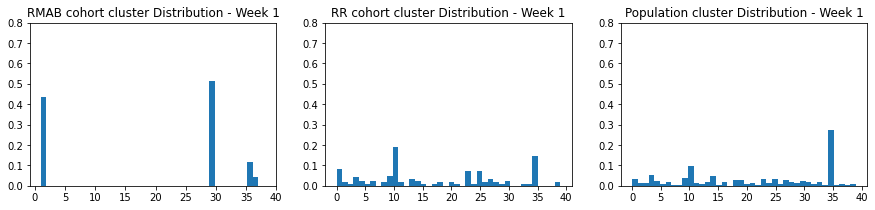

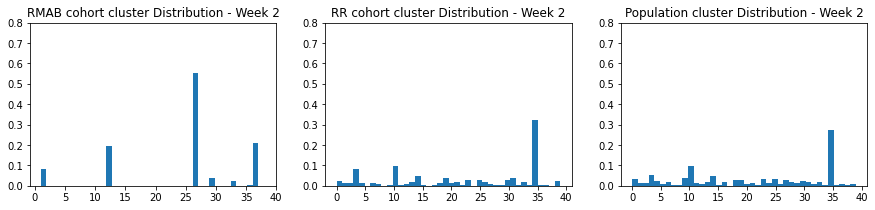

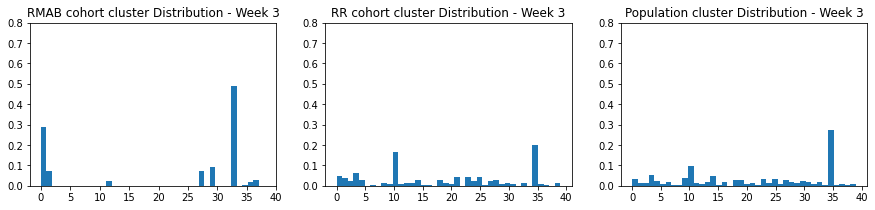

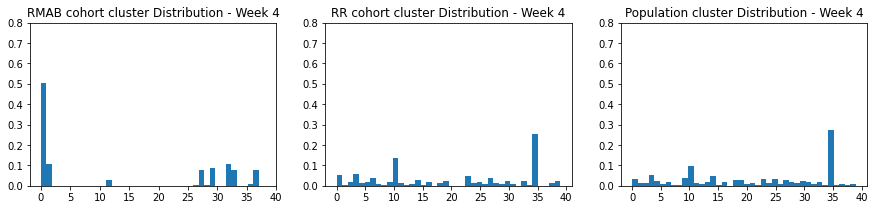

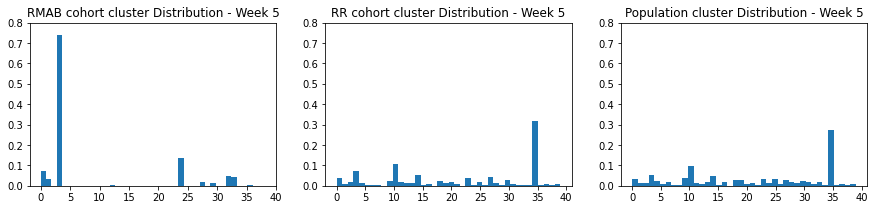

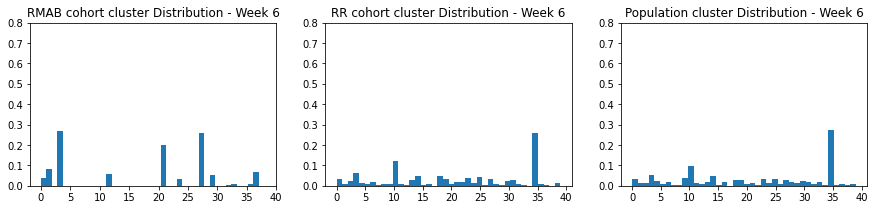

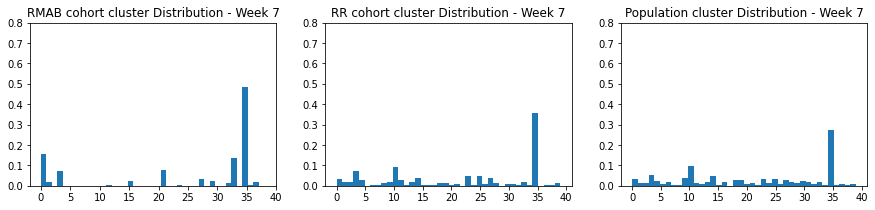

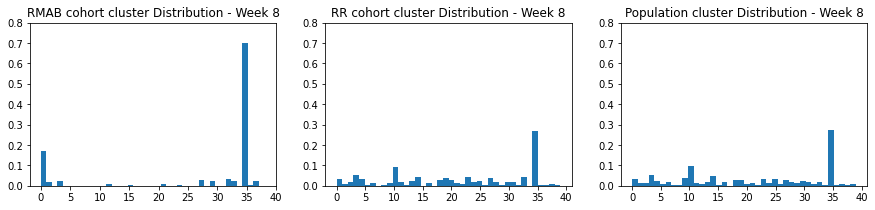

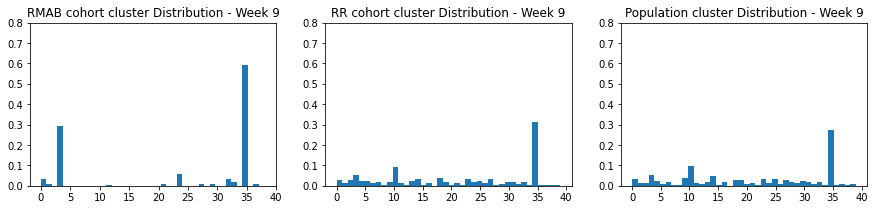

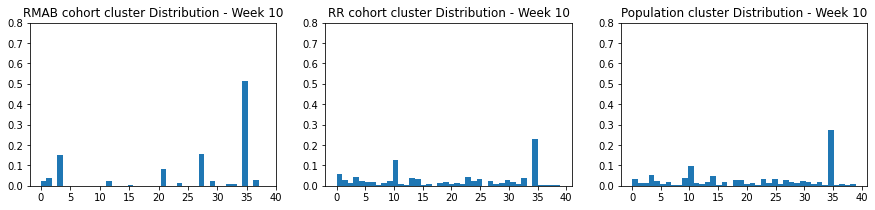

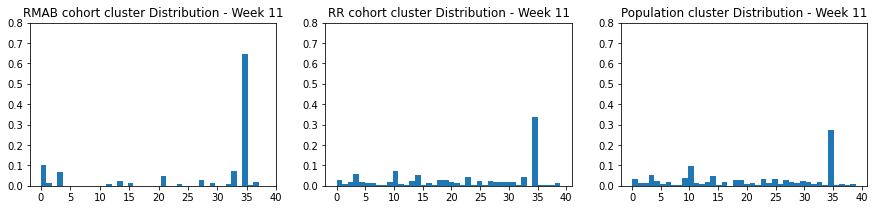

In [74]:
for i in range(T-1):
    plt.figure(figsize=(15, 3))
    sub = interv_df[interv_df['intervene_week']==f'week{i+1}']
    plt.subplot(1,3,1)
    plt.hist(sub[sub['exp_group']=='rmab']['cluster'].values,density=True, bins=40)
    plt.ylim(0, 0.8)
    plt.xticks([5*(i) for i in range(9)],
          [str(5*(i)) for i in range(9)])
    plt.title(f'RMAB cohort cluster Distribution - Week {i+1}')
    plt.subplot(1,3,2)
    plt.hist(sub[sub['exp_group']=='round_robin']['cluster'].values, density=True, bins=40)
    plt.ylim(0, 0.8)
    plt.xticks([5*(i) for i in range(9)],
          [str(5*(i)) for i in range(9)])
    plt.title(f'RR cohort cluster Distribution - Week {i+1}')
    plt.subplot(1,3,3)
    plt.hist(analysis_df['cluster'].values, density=True, bins=40)
    plt.ylim(0, 0.8)
    plt.xticks([5*(i) for i in range(9)],
          [str(5*(i)) for i in range(9)])
    plt.title(f'Population cluster Distribution - Week {i+1}')

    

In [23]:
interv_df['intervene_week'].value_counts()

week10    1000
week8     1000
week9     1000
week11    1000
week7      700
week6      600
week5      435
week4      400
week2      400
week3      400
week1      250
Name: intervene_week, dtype: int64

In [18]:
all_df = pd.read_csv('outputs/state-cluster-whittle-E_C.csv')
interv_df = pd.read_csv('outputs/interventions.csv')
all_df
interv_df[(interv_df['exp_group']=='rmab') & (interv_df['intervene_week']=='week8')]['cluster'].value_counts()

35    324
0      79
32     16
27     13
33     12
3      12
37     11
29     11
1       8
21      5
12      4
36      2
24      2
15      1
Name: cluster, dtype: int64

In [22]:
interv_df[(interv_df['exp_group']=='rmab')]['cluster'].value_counts()

35    1295
3      503
0      375
27     318
33     223
1      170
29     156
21     148
37     126
12      83
24      78
32      77
36      29
15      16
13      11
28       1
26       1
Name: cluster, dtype: int64

In [ ]:
population cluster distr
total pulls RMAB cluster ditribution - upto including week 6
top two clusters who got pulled vs population - t-test
no pulls cluster  - t-test

In [19]:
m_values[35]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.39415741, -0.00360489])

In [219]:
lookup = {7:'NE', 6:'E', 0:'Sleep_E', 1:'Sleep_NE'}

def dist_stat(df, col):
    new_df = pd.DataFrame({'Proportion':df[col].value_counts(normalize=True),
                         'Count':df[col].value_counts()})
    new_df.index = pd.Series(new_df.index).replace(lookup)
    cols = np.sort(new_df.index)
    return new_df.loc[cols]

Week0
rmab
    Proportion  Count
E     0.465702   3571
NE    0.534298   4097

RR
    Proportion  Count
E     0.475613   3647
NE    0.524387   4021

All
    Proportion  Count
E     0.477501   3661
NE    0.522499   4006


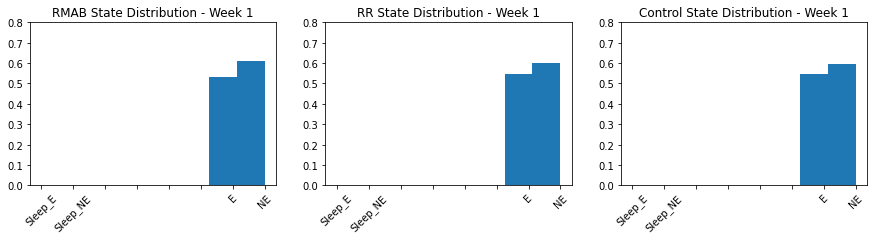




Week1
rmab
          Proportion  Count
E           0.459572   3524
NE          0.524126   4019
Sleep_E     0.002999     23
Sleep_NE    0.013302    102

RR
          Proportion  Count
E           0.453312   3476
NE          0.530386   4067
Sleep_E     0.005999     46
Sleep_NE    0.010303     79

All
    Proportion  Count
E     0.462632   3547
NE    0.537368   4120


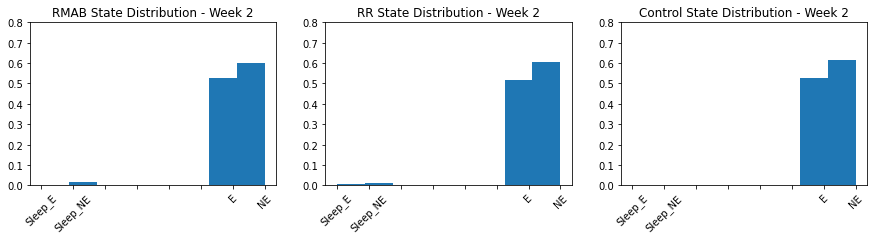




Week2
rmab
          Proportion  Count
E           0.436881   3350
NE          0.520736   3993
Sleep_E     0.018127    139
Sleep_NE    0.024257    186

RR
          Proportion  Count
E           0.430360   3300
NE          0.527256   4043
Sleep_E     0.017084    131
Sleep_NE    0.025300    194

All
    Proportion  Count
E     0.449328   3445
NE    0.550672   4222


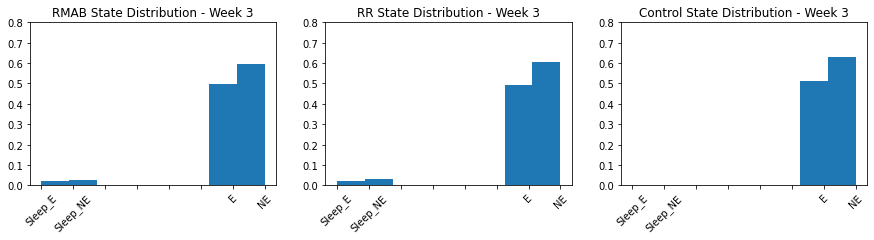




Week3
rmab
          Proportion  Count
E           0.417188   3199
NE          0.517606   3969
Sleep_E     0.029864    229
Sleep_NE    0.035342    271

RR
          Proportion  Count
E           0.419144   3214
NE          0.517084   3965
Sleep_E     0.028951    222
Sleep_NE    0.034820    267

All
    Proportion  Count
E     0.454285   3483
NE    0.545715   4184


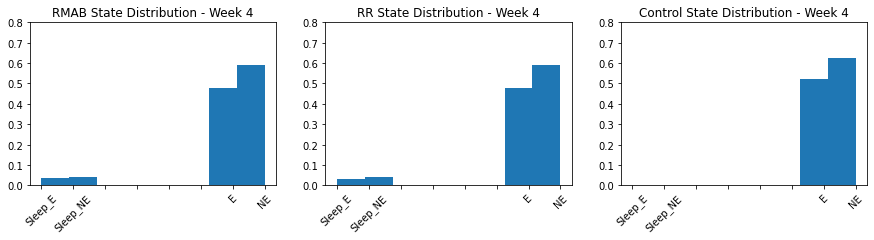




Week4
rmab
          Proportion  Count
E           0.392149   3007
NE          0.535211   4104
Sleep_E     0.038211    293
Sleep_NE    0.034429    264

RR
          Proportion  Count
E           0.395409   3032
NE          0.526343   4036
Sleep_E     0.033255    255
Sleep_NE    0.044992    345

All
    Proportion  Count
E     0.436938   3350
NE    0.563062   4317


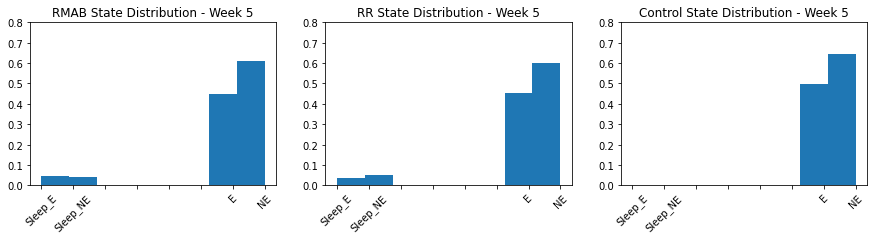




Week5
rmab
          Proportion  Count
E           0.385889   2959
NE          0.533777   4093
Sleep_E     0.050600    388
Sleep_NE    0.029734    228

RR
          Proportion  Count
E           0.402321   3085
NE          0.519431   3983
Sleep_E     0.036776    282
Sleep_NE    0.041471    318

All
    Proportion  Count
E      0.43159   3309
NE     0.56841   4358


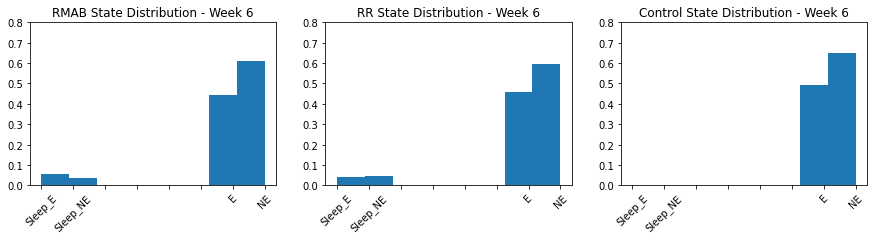




Week6
rmab
          Proportion  Count
E           0.368153   2823
NE          0.535994   4110
Sleep_E     0.058555    449
Sleep_NE    0.037298    286

RR
          Proportion  Count
E           0.390975   2998
NE          0.517736   3970
Sleep_E     0.042384    325
Sleep_NE    0.048905    375

All
    Proportion  Count
E     0.430025   3297
NE    0.569975   4370


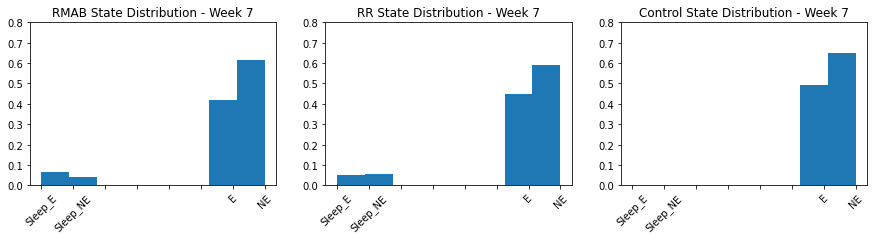




Week7
rmab
          Proportion  Count
E           0.356808   2736
NE          0.527778   4047
Sleep_E     0.072509    556
Sleep_NE    0.042906    329

RR
          Proportion  Count
E           0.380412   2917
NE          0.508738   3901
Sleep_E     0.052556    403
Sleep_NE    0.058294    447

All
    Proportion  Count
E     0.424155   3252
NE    0.575845   4415


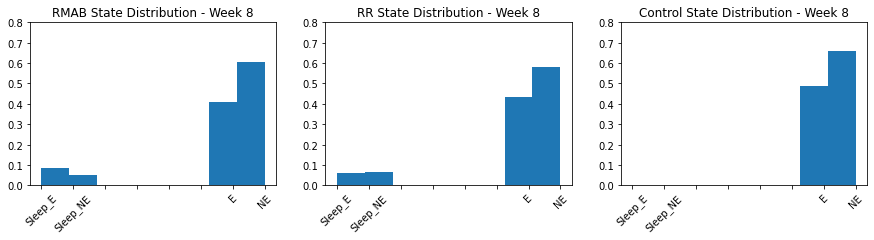




Week8
rmab
          Proportion  Count
E           0.333073   2554
NE          0.516954   3964
Sleep_E     0.095722    734
Sleep_NE    0.054251    416

RR
          Proportion  Count
E           0.365415   2802
NE          0.484611   3716
Sleep_E     0.066249    508
Sleep_NE    0.083725    642

All
    Proportion  Count
E     0.424938   3258
NE    0.575062   4409


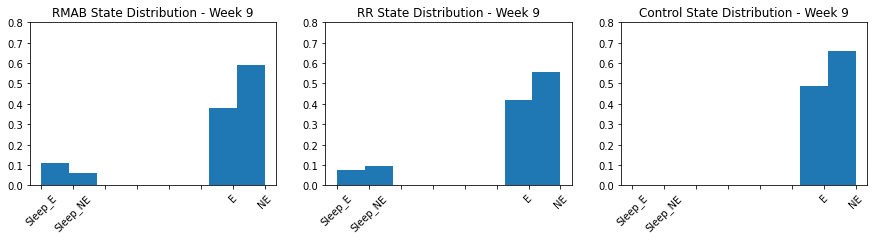




Week9
rmab
          Proportion  Count
E           0.301643   2313
NE          0.522300   4005
Sleep_E     0.128195    983
Sleep_NE    0.047861    367

RR
          Proportion  Count
E           0.353026   2707
NE          0.470918   3611
Sleep_E     0.081638    626
Sleep_NE    0.094418    724

All
    Proportion  Count
E     0.427155   3275
NE    0.572845   4392


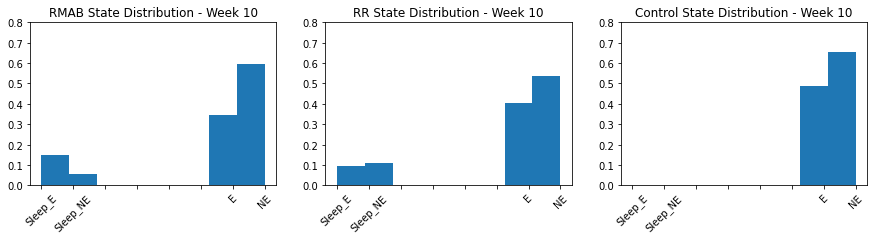




Week10
rmab
          Proportion  Count
E           0.285994   2193
NE          0.518388   3975
Sleep_E     0.135368   1038
Sleep_NE    0.060250    462

RR
          Proportion  Count
E           0.339463   2603
NE          0.464919   3565
Sleep_E     0.084637    649
Sleep_NE    0.110981    851

All
    Proportion  Count
E     0.409417   3139
NE    0.590583   4528


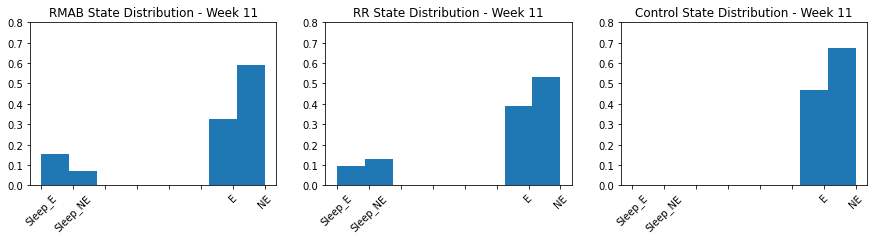

In [53]:

for i in range(T-1):
    print(f'Week{i}')
    bins=8
    plt.figure(figsize=(15, 3))
    
    
    plt.subplot(1,3,1)
    plt.hist(analysis_df[analysis_df['arm']=='rmab'][f'week{i}_state'],density=True, bins=bins, range=(0,7))
    plt.ylim(0, 0.8)
    plt.xticks([(i) for i in range(8)],
          [lookup[i] if i in lookup else '' for i in range(8)], rotation=45)
    print('rmab')
    print(dist_stat(analysis_df[analysis_df['arm']=='rmab'], f'week{i}_state'))
    plt.title(f'RMAB State Distribution - Week {i+1}')
    
    
    plt.subplot(1,3,2)
    plt.hist(analysis_df[analysis_df['arm']=='round_robin'][f'week{i}_state'].values, density=True, bins=bins, range=(0,7))
    plt.ylim(0, 0.8)
    plt.xticks([(i) for i in range(8)],
          [lookup[i] if i in lookup else '' for i in range(8)], rotation=45)
    print('\nRR')
    print(dist_stat(analysis_df[analysis_df['arm']=='round_robin'], f'week{i}_state'))
    plt.title(f'RR State Distribution - Week {i+1}')
    
    
    plt.subplot(1,3,3)
    plt.hist(analysis_df[analysis_df['arm']=='control'][f'week{i}_state'].values, density=True, bins=bins, range=(0,7))
    plt.ylim(0, 0.8)
    plt.xticks([(i) for i in range(8)],
          [lookup[i] if i in lookup else '' for i in range(8)], rotation=45)
    print('\nAll')
    print(dist_stat(analysis_df[analysis_df['arm']=='control'], f'week{i}_state'))
    plt.title(f'Control State Distribution - Week {i+1}')
    
    
    plt.show()
    print('\n\n')
    

    

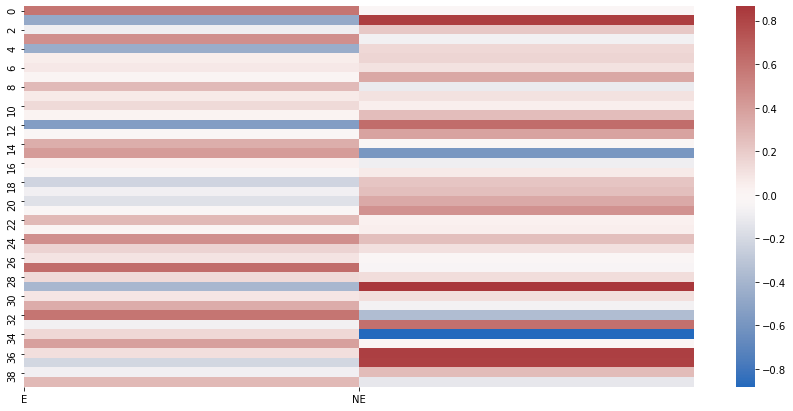

In [5]:
import seaborn as sns
plt.figure(figsize=(15, 7))
sns.heatmap(m_values[:, 6:], cmap="vlag")
plt.xticks([0,1], ['E', 'NE'])
plt.show()

In [11]:
m_values[35][-2:], m_values[34][-2:], np.sort(m_values[:, -2]), np.sort(m_values[:, -1])

(array([ 0.39415741, -0.00360489]),
 array([ 0.14500427, -0.8828125 ]),
 array([-0.54520416, -0.46795654, -0.45119476, -0.38793945, -0.22155762,
        -0.21250916, -0.1570282 , -0.08378601, -0.07807922, -0.07689667,
        -0.07536316, -0.03503418, -0.03092957, -0.02336121,  0.00747681,
         0.01118469,  0.02032471,  0.0380249 ,  0.05822754,  0.068367  ,
         0.0785675 ,  0.09329224,  0.10005188,  0.12039185,  0.1348877 ,
         0.13707733,  0.14500427,  0.16575623,  0.2754364 ,  0.28073883,
         0.28222656,  0.32649231,  0.33354187,  0.39415741,  0.41239929,
         0.46517181,  0.46569824,  0.58795166,  0.59016418,  0.63092804]),
 array([-8.82812500e-01, -5.87753296e-01, -3.50891113e-01, -1.18591309e-01,
        -1.08581543e-01, -8.58154297e-02, -7.44018555e-02, -6.49261475e-02,
        -4.05731201e-02, -1.36184692e-02, -1.22833252e-02, -3.60488892e-03,
        -8.01086426e-04,  3.91159058e-02,  5.02166748e-02,  5.16281128e-02,
         7.14950562e-02,  1.01840973e-

(array([  1.,   2.,   3.,   3.,  16., 267.,  11.,   8.,   5.,   4.]),
 array([-0.8828125 , -0.70796204, -0.53311157, -0.35826111, -0.18341064,
        -0.00856018,  0.16629028,  0.34114075,  0.51599121,  0.69084167,
         0.86569214]),
 <BarContainer object of 10 artists>)

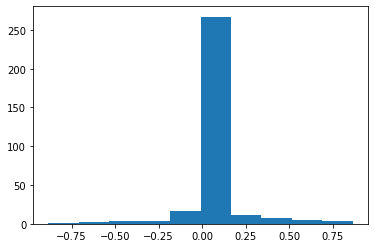

In [138]:
plt.hist(m_values.flatten(), bins=10)

In [228]:
p_cols = [c for c in cluster_transition_probabilities if c.startswith('P')]
(cluster_transition_probabilities[p_cols]-cluster_transition_probabilities[p_cols].min())/(cluster_transition_probabilities[p_cols].max()-cluster_transition_probabilities[p_cols].min())

,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)"
0,0.606826,0.393174,0.466667,0.533333,0.167384,0.832616,0.257571,0.742429
1,0.528191,0.471809,0.875000,0.125000,0.753917,0.246083,0.294300,0.705700
2,0.528191,0.471809,0.631579,0.368421,0.613110,0.386890,0.440722,0.559278
3,0.115358,0.884642,0.157895,0.842105,0.000000,1.000000,0.180060,0.819940
4,0.213652,0.786348,0.176471,0.823529,0.548298,0.451702,0.047940,0.952060
5,0.950853,0.049147,0.985655,0.014345,0.895274,0.104726,0.795333,0.204667
6,0.494490,0.505510,0.428571,0.571429,0.458539,0.541461,0.263401,0.736599
7,0.937920,0.062080,0.479162,0.520838,1.000000,0.000000,0.288538,0.711462
8,0.571083,0.428917,0.545455,0.454545,0.427206,0.572794,0.493250,0.506750
9,0.295501,0.704499,0.277778,0.722222,0.274078,0.725922,0.108151,0.891849


In [232]:
p_cols = [c for c in cluster_transition_probabilities if c.startswith('P')]
ctp = cluster_transition_probabilities.copy()
ctp[p_cols] = (cluster_transition_probabilities[p_cols]-cluster_transition_probabilities[p_cols].min())/(cluster_transition_probabilities[p_cols].max()-cluster_transition_probabilities[p_cols].min())
ctp

,cluster,count,"P(E, I, E)","P(E, I, NE)","P(NE, I, E)","P(NE, I, NE)","P(E, A, E)","P(E, A, NE)","P(NE, A, E)","P(NE, A, NE)"
0,0.0,169.0,0.606826,0.393174,0.466667,0.533333,0.167384,0.832616,0.257571,0.742429
1,1.0,83.0,0.528191,0.471809,0.875000,0.125000,0.753917,0.246083,0.294300,0.705700
2,2.0,104.0,0.528191,0.471809,0.631579,0.368421,0.613110,0.386890,0.440722,0.559278
3,3.0,204.0,0.115358,0.884642,0.157895,0.842105,0.000000,1.000000,0.180060,0.819940
4,4.0,129.0,0.213652,0.786348,0.176471,0.823529,0.548298,0.451702,0.047940,0.952060
5,5.0,50.0,0.950853,0.049147,0.985655,0.014345,0.895274,0.104726,0.795333,0.204667
6,6.0,128.0,0.494490,0.505510,0.428571,0.571429,0.458539,0.541461,0.263401,0.736599
7,7.0,53.0,0.937920,0.062080,0.479162,0.520838,1.000000,0.000000,0.288538,0.711462
8,8.0,75.0,0.571083,0.428917,0.545455,0.454545,0.427206,0.572794,0.493250,0.506750
9,9.0,117.0,0.295501,0.704499,0.277778,0.722222,0.274078,0.725922,0.108151,0.891849


In [229]:
T = 12
def get_prob(string):
    cluster = int(string.split('-')[0])
    state = string.split('-')[1]
    if state=='E' or state=='Sleep_E':
        state = 'E'
    else:
        state = 'NE'
    p_cols = [c for c in cluster_transition_probabilities if c.startswith('P')]
    ctp = cluster_transition_probabilities.copy()
    ctp[p_cols] = (cluster_transition_probabilities[p_cols]-cluster_transition_probabilities[p_cols].min())/(cluster_transition_probabilities[p_cols].max()-cluster_transition_probabilities[p_cols].min())
    prob_i = ctp.loc[cluster][f'P({state}, I, E)']
    prob_a = ctp.loc[cluster][f'P({state}, A, NE)']
    return prob_i, prob_a

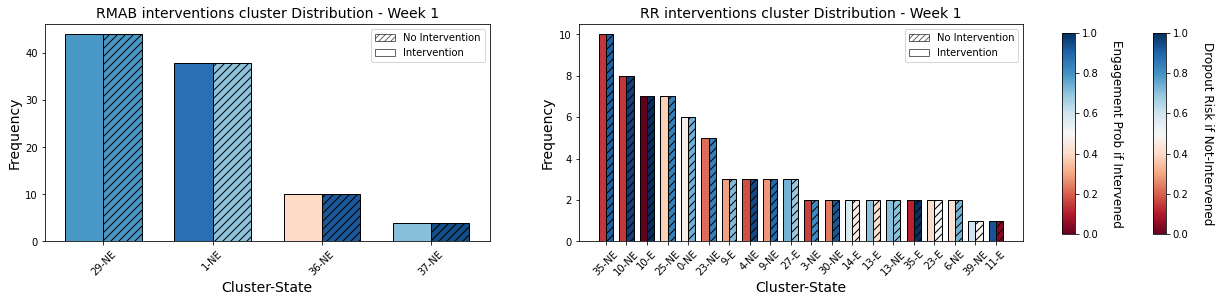

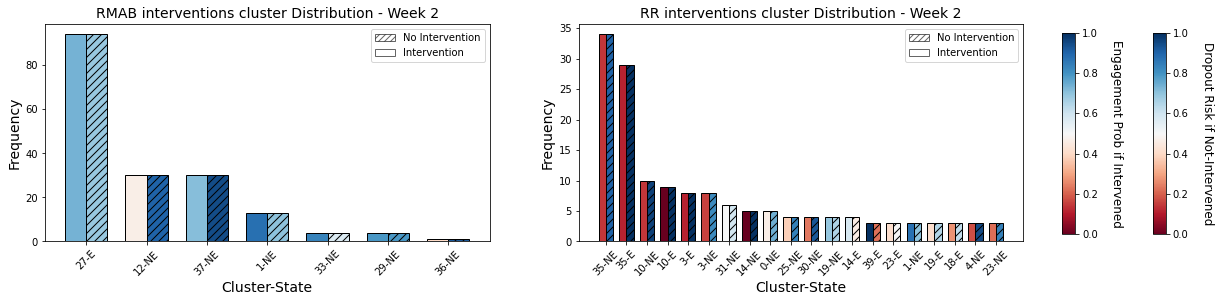

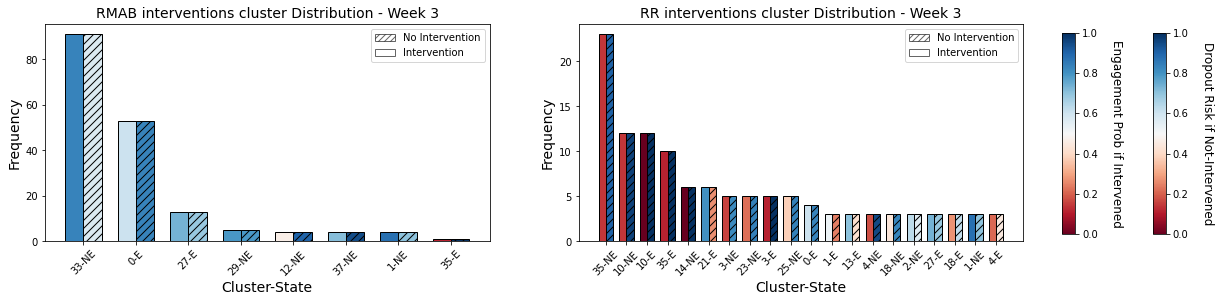

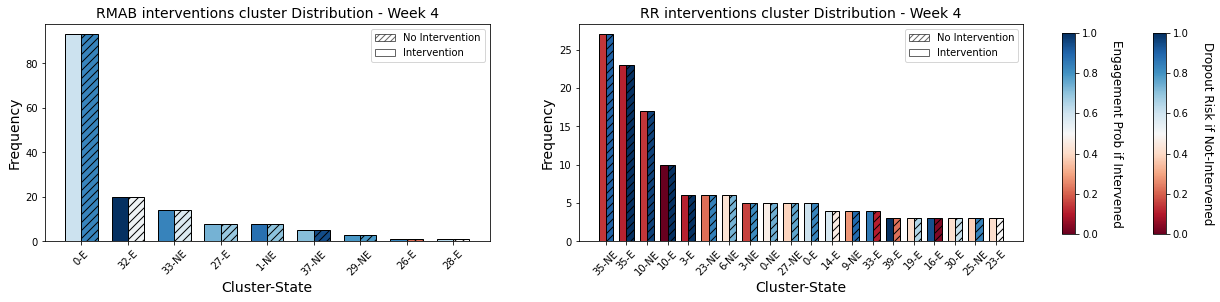

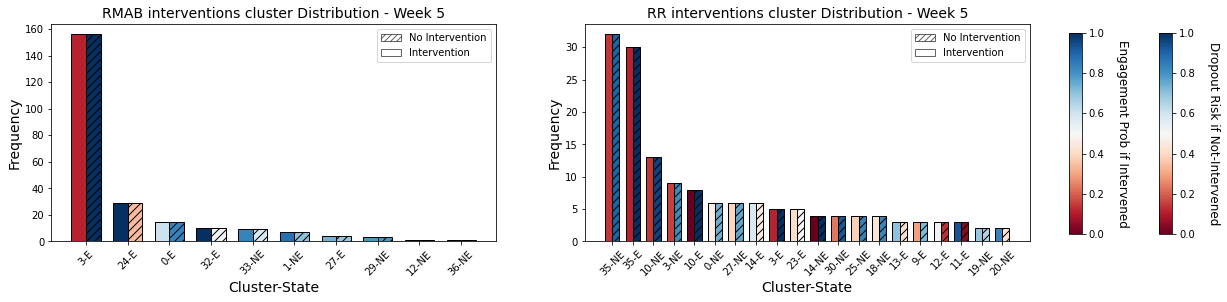

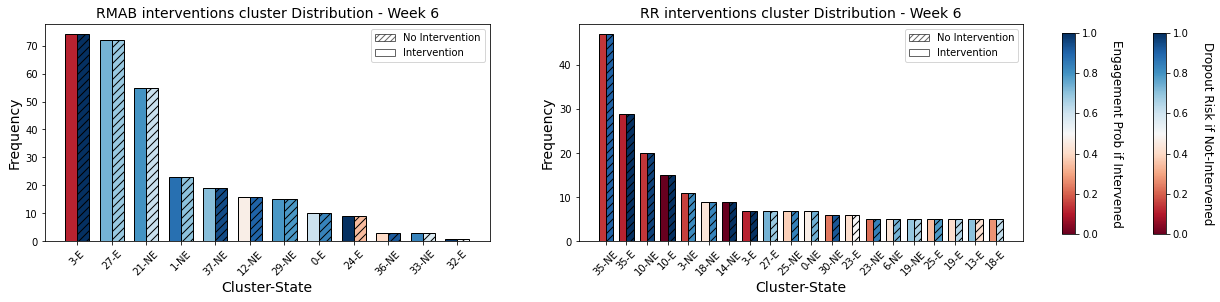

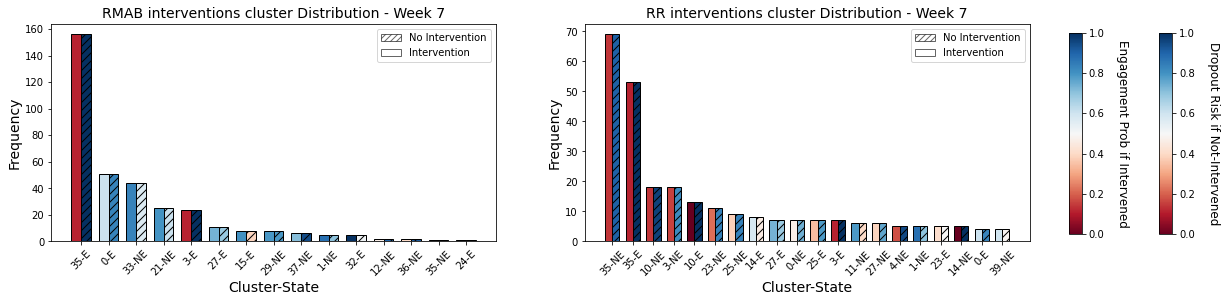

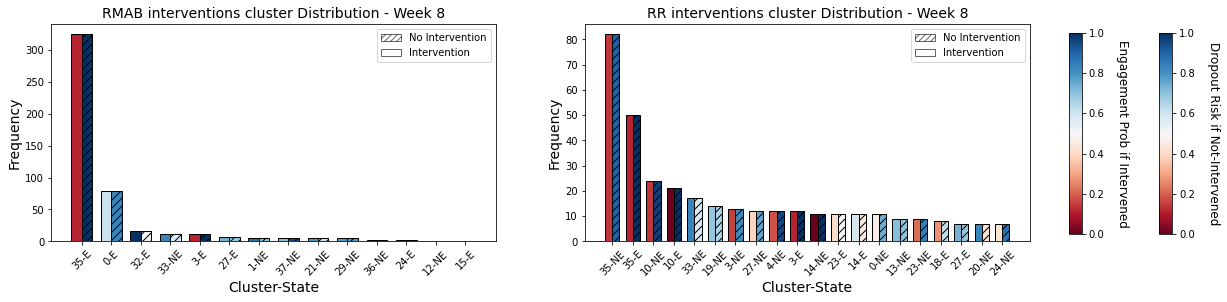

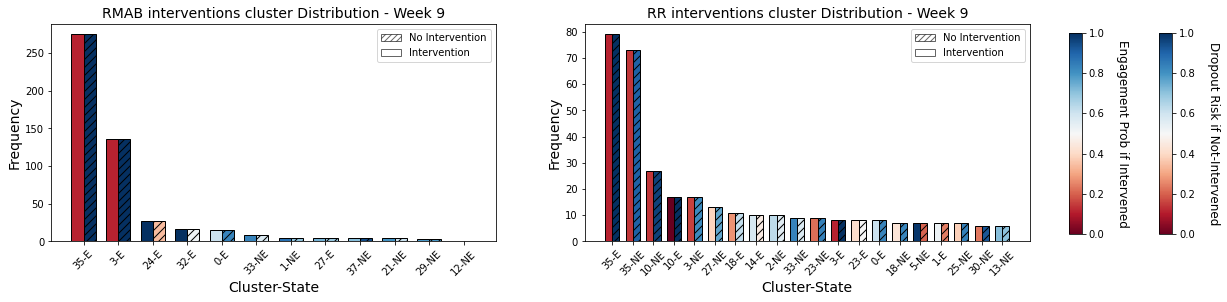

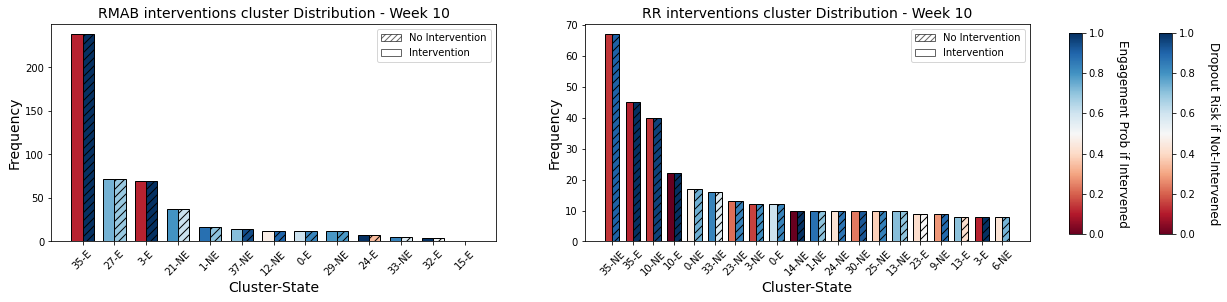

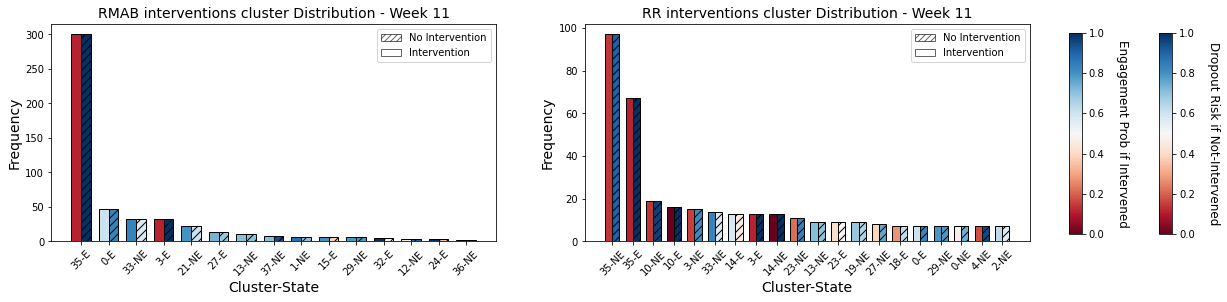

In [230]:
from matplotlib.cm import ScalarMappable
import matplotlib.patches as mpatches

width = 0.35
risk_spectrum = 'RdBu'
success_spectrum = 'RdBu'
succ_cmap = plt.cm.get_cmap(success_spectrum)
risk_cmap = plt.cm.get_cmap(risk_spectrum)

for i in range(T-1):
    plt.figure(figsize=(18, 4))
    sub = interv_df[interv_df['intervene_week']==f'week{i+1}']
    sub = sub[~sub.user_id.isin(bad_users)]
    sub = pd.merge(sub, analysis_df[['user_id', f'week{i}_state']])
    sub['cluster_state'] = sub['cluster'].astype(str)+'-'+sub[f'week{i}_state'].replace(lookup)
    
    
    plt.subplot(1,2,1)
    vc = sub[sub['exp_group']=='rmab']['cluster_state'].value_counts()[:20]
    data_color_normalized = [get_prob(col)[0] for col in vc.index]
    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc))-width/2, vc.values, edgecolor='black', width=width, color=colors)

    
    vc = sub[sub['exp_group']=='rmab']['cluster_state'].value_counts()[:20]
    data_color_normalized = [get_prob(col)[1] for col in vc.index]
    colors = risk_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=risk_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc))+width/2, vc.values, edgecolor='black', hatch='///', width=width, color=colors)

    
#     plt.xticks(list(np.arange(len(vc))-width/2)+list(np.arange(len(vc))+width/2),
#           [i+'-I' for i in vc.index]+[i+'-A' for i in vc.index], rotation=90, fontsize=10)
    plt.xticks(list(np.arange(len(vc))),
          [i for i in vc.index], rotation=45, fontsize=10)
    plt.xlabel('Cluster-State', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    


    a_val = 0.6
    colors = ['#FFFFFF','#FEFFBE','#4BB05C']


    circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'////', edgecolor='black', label='No Intervention')
    circ2= mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=' ', edgecolor='black', label='Intervention')

    plt.legend(handles = [circ1,circ2])

    plt.title(f'RMAB interventions cluster Distribution - Week {i+1}', fontsize=14)
    
    
    
    
    
    plt.subplot(1,2,2)
    vc = sub[sub['exp_group']=='round_robin']['cluster_state'].value_counts().iloc[:20]
    data_color_normalized = [get_prob(col)[0] for col in vc.index]
    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc))-width/2, vc.values, edgecolor='black', width=width, color=colors)

    
    vc = sub[sub['exp_group']=='round_robin']['cluster_state'].value_counts().iloc[:20]
    data_color_normalized = [get_prob(col)[1] for col in vc.index]
    colors = risk_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=risk_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])

    plt.bar(np.arange(len(vc))+width/2, vc.values, edgecolor='black', hatch='///', width=width, color=colors)

    
#     plt.xticks(list(np.arange(len(vc))-width/2)+list(np.arange(len(vc))+width/2),
#           [i+'-I' for i in vc.index]+[i+'-A' for i in vc.index], rotation=90, fontsize=10)
    plt.xticks(list(np.arange(len(vc))),
          [i for i in vc.index], rotation=45, fontsize=10)
    plt.xlabel('Cluster-State', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    


    a_val = 0.6
    colors = ['#FFFFFF','#FEFFBE','#4BB05C']


    circ1 = mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=r'////', edgecolor='black', label='No Intervention')
    circ2= mpatches.Patch( facecolor=colors[0],alpha=a_val,hatch=' ', edgecolor='black', label='Intervention')

    plt.legend(handles = [circ1,circ2])

    plt.title(f'RR interventions cluster Distribution - Week {i+1}', fontsize=14)
    
    fig = plt.gcf()
    fig.subplots_adjust(right=0.88)
    cbar_ax_1 = fig.add_axes([0.91, 0.15, 0.01, 0.7])
    cbar_ax_2 = fig.add_axes([0.98, 0.15, 0.01, 0.7])

    colors = succ_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=succ_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax_1)
    cbar.set_label('Engagement Prob if Intervened', rotation=270,labelpad=25, fontsize=12)
    
    colors = risk_cmap(data_color_normalized)
    sm = ScalarMappable(cmap=risk_cmap, norm=plt.Normalize(0,1))
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax_2)
    cbar.set_label('Dropout Risk if Not-Intervened', rotation=270,labelpad=25, fontsize=12)
    
#     plt.tight_layout()
    
    

    